## DeepSea Pipeline:

This is the code to run the minimal working example for LDSC with DeepSea Integration. The code will train the deepsea model on the set of features provided using the .yml file on the google drive folder, get predictions on the reference genome from the trained model, and run LDSC on the resulting predictions to output enrichments. 

If you would like to use a different set of features or change training parameters, please edit the .yml file provided and everything else will still work.

## Command Interface:

This is the list of commands and workflows with explanations for each one, detailed information for each step will be presented below.

In [23]:
!sos run LDSC_DeepSea_Code.ipynb -h


No help information is available for script run: Failed to locate LDSC_DeepSea_Code.ipynb.sos


## Background:

DeepSea is a deep learning model developed by researchers at Princeton University to integrate epigenomic feature data and generate functional predictions for these features on input variants given by the user. DeepSEA can accurately predict the epigenetic state of a sequence, including transcription factors binding, DNase I sensitivities and histone marks in multiple cell types, and further utilize this capability to predict the chromatin effects of sequence variants and prioritize regulatory variants. This model allows for the user to predict effects based on an increased context such as a 1 kB window around the variant which allows for better accuracy and predictions from the model. 

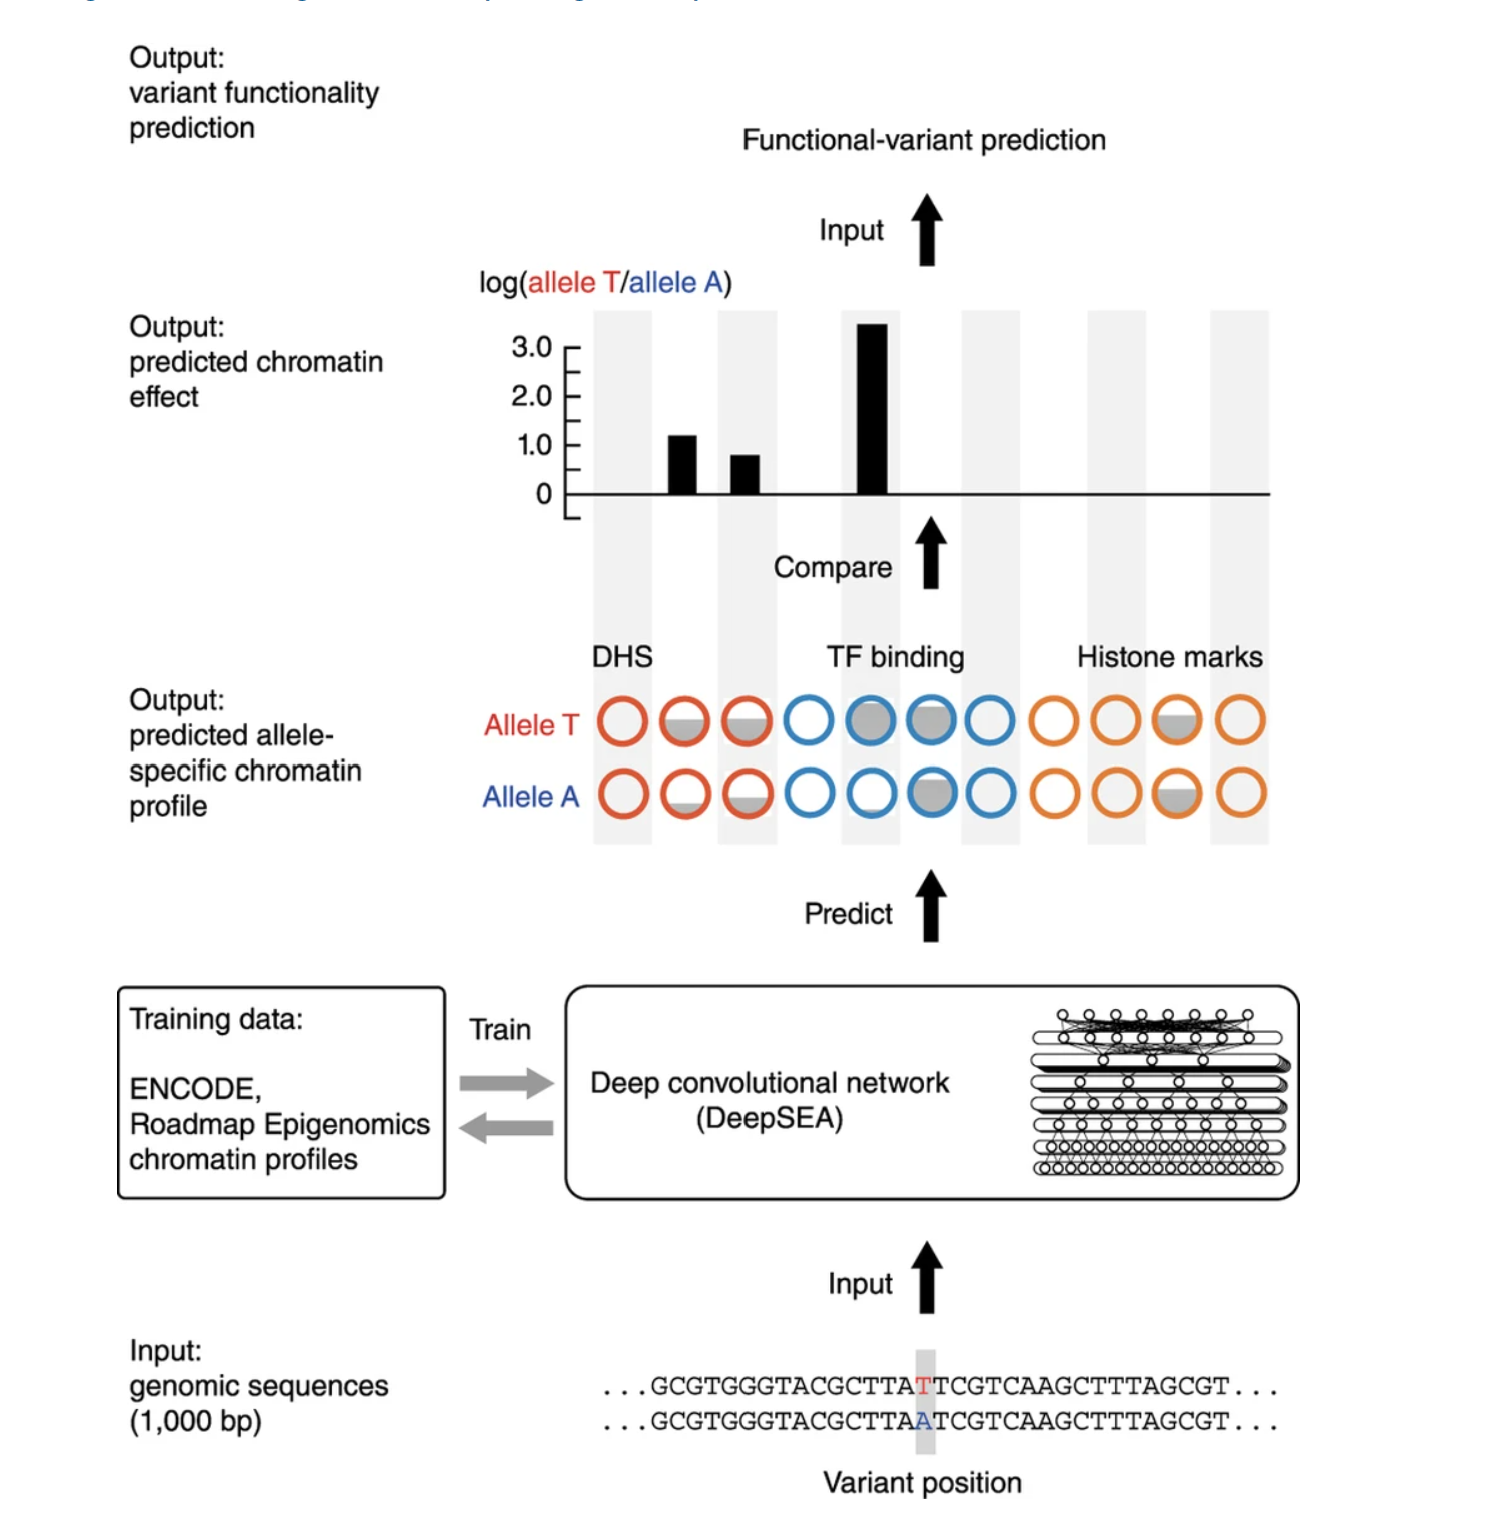

This diagram shows the DeepSea pipeline. First the model takes an input of 1 kB sequence from the reference genome and trains the model on epigenomic features such as DNase Sites and TFs. Then, using the trained model you can generate functional predictions, predictions of the effect the variant will have on the features in the model, on your own set of variants. These predictions can be used to identify and priortize functionally important variants for certain features in your model.

For more background and information please refer two two papers written by the creaters at Princeton University:

1. [Predicting effects of noncoding variants with deep learning–based sequence model](https://www.nature.com/articles/nmeth.3547)

2. [Whole-genome deep-learning analysis identifies contribution of noncoding mutations to autism risk](https://www.nature.com/articles/s41588-019-0420-0)

## Training Model: 

**Workflow Command to train model for Minimal Example:** `sos run LDSC_DeepSea_Code.ipynb train_model`

To train the model using different data you can use the .yml file provided to change the training parameters and files. An example of how this file looks for the minimal working example is shown below.

In [21]:
with open('all_neuron_tutorial.yml') as f:
    contents = f.read()
    print(contents)

---
ops: [train, evaluate]
model: {
    path: /mnt/mfs/statgen/Anmol/training_files/deeperdeepsea.py,#UPDATE
    class: DeeperDeepSEA,
    class_args: {
        sequence_length: 1000,
        n_targets: 7,
    },
    non_strand_specific: mean
}
sampler: !obj:selene_sdk.samplers.IntervalsSampler {
    reference_sequence: !obj:selene_sdk.sequences.Genome {
        input_path: /mnt/mfs/statgen/Anmol/training_files/male.hg19.fasta,#UPDATE
        blacklist_regions: hg19
    },
    features: !obj:selene_sdk.utils.load_features_list {
        input_path: /mnt/mfs/statgen/Anmol/training_files/tutorial/tutorial_features.txt #UPDATE
    },
    target_path: /mnt/mfs/statgen/Anmol/training_files/tutorial/tutorial.bed.gz, #UPDATE
    intervals_path: /mnt/mfs/statgen/Anmol/training_files/DNase_Intervals_FULL.txt, #UPDATE
    seed: 127,
    # A positive example is an 1000bp sequence with at least 1 class/feature annotated to it.
    # A negative sample has no classes/features annotated to the sequen

Above shows the .yml file used to train the minimal working example model in this workflow. 

To use your own data you must update the:

**1. n_targets (Number of Features you are training on):

`n_targets: 7`

**2. Feature list file (a list of all the distinct features you are training on):

`features: !obj:selene_sdk.utils.load_features_list {
        input_path: /mnt/mfs/statgen/Anmol/training_files/tutorial/tutorial_features.txt #UPDATE
    }`
    
**3. Target Path File (A combined bed file for all of your features):

`target_path: /mnt/mfs/statgen/Anmol/training_files/tutorial/tutorial.bed.gz, #UPDATE`

**4. Max_Steps (Maximum number of Training Steps), n_validation_samples (Number of Validation Samples), n_test_samples (Number of Testing Samples):

`train_model: !obj:selene_sdk.TrainModel {
    batch_size: 64,
    max_steps: 501,  # update this value for longer training
    report_stats_every_n_steps: 250,
    n_validation_samples: 6000,
    n_test_samples: 22000,
    cpu_n_threads: 32,
    use_cuda: False,  # TODO: update this if CUDA is not on your machine
    data_parallel: False
}`

Generally you want to train until the validation and training loss are not decreasing anymore. For the full 2032 features example, I have found that this occurs at around 250,000 training steps which is what I set the max_steps parameter to for that case. Depending on how many features you are using, this could be more or less. You will want to change how frequently the model statistics (ROC,AUC, etc) are outputted especially if you are training on a large number of steps. For 250,000 steps, I would recommend setting the `report_stats_every_n_steps` parameter to 10,000 so you can assess how the model is training frequently enough but you are not wasting too much time calculating the ROC and AUC too frequently. For Validation and Testing Samples, I used 40,000 and 500,000 respectively for 2032 features. Again this will depend on the amount of features you have so adjust this number to be more or less depending on the number of features you are training the model on. 

## Getting Predictions from Trained Model:

**Workflow Command to get predictions from trained model for Minimal Example:** 

`sos run LDSC_DeepSea_Minimal_Example.ipynb make_annot --feature_list /mnt/mfs/statgen/Anmol/training_files/tutorial/tutorial_features.txt --model /mnt/mfs/statgen/Anmol/training_files/tutorial/tutorial/training_outputs/model --output_tsv /mnt/mfs/statgen/Anmol/training_files/tutorial/testing --num_features 7 --vcf /mnt/mfs/statgen/Anmol/training_files/tutorial/tutorial_1000G_chr_`

**Explanations of Parameters so that you can change to run with your own data:**

**1. feature_list: Path to list of distinct features, same as one used in .yml file

**2. model: Path to location of trained model folder, is the output_dir parameter in the .yml training file

**3. output_tsv: Path to directory where you want to output the predictions to 

**4. num_features: Number of Features you trained the model on

**5. vcf: Path to location of reference genome vcf files you want to use for predictions, program will append the chromosome number and .vcf to the end of file name automatically to loop over all the chromosomes so format file name in command as `1000G_chr_` and leave the chr numbers and .vcf out. 

## Formatting Resulting Predictions to Annotation File for LDSC: 

**Workflow Command to format Prediction files to LDSC Annotation Files:** 

`sos run LDSC_DeepSea_Minimal_Example.ipynb format_annot --tsv /mnt/mfs/statgen/Anmol/training_files/tutorial/testing --annot_files /mnt/mfs/statgen/Anmol/training_files/tutorial/annot_files`

**Explanations of Parameters so that you can change to run with your own data:**

**1. tsv: Path to where prediction files (.tsv files) are located

**2. annot_files: Path to location where you want the annotation files to be outputted

## Train Model:

In [93]:

[train_model]

bash: container='/mnt/mfs/statgen/Anmol/deepsea_latest.sif'

    python3.7 /mnt/mfs/statgen/Anmol/training_files/tutorial/run_neuron_full_tutorial.py 

## Make Full Annotation File Based on Trained Model

In [ ]:
# Get Predictions for Features based on Trained Model


[make_annot]

#path to feature list file
parameter: feature_list = str
#path to trained model location
parameter: model = str
#path to output directory
parameter: output_tsv = str
#number of features
parameter: num_features = int
#VCF files for Reference Genome [Give in this format: tutorial_1000G_chr_, as program will loop over chromsomes and add vcf extension automatically]
parameter: vcf = str()


python3: container='/mnt/mfs/statgen/Anmol/deepsea_latest.sif',expand = "${ }"

    from selene_sdk.utils import load_path
    from selene_sdk.utils import parse_configs_and_run
    from selene_sdk.predict import AnalyzeSequences
    from selene_sdk.sequences import Genome
    from selene_sdk.utils import load_features_list
    from selene_sdk.utils import NonStrandSpecific
    from selene_sdk.utils import DeeperDeepSEA
    import glob
    import os
    distinct_features = load_features_list('${feature_list}')

    model_predict = AnalyzeSequences(
    NonStrandSpecific(DeeperDeepSEA(1000,${num_features})),
    '${model}'+"/best_model.pth.tar",
    sequence_length=1000,
    features=distinct_features,
    reference_sequence=Genome("/mnt/mfs/statgen/Anmol/training_files/male.hg19.fasta"),
    use_cuda=False # update this to False if you do not have CUDA on your machine.
    )

    for i in range(1,23):
        model_predict.variant_effect_prediction(
        ${vcf}+str(i)+".vcf",
        save_data=["abs_diffs"],  # only want to save the absolute diff score data
        output_dir='${output_tsv}')

## Format Annotation File

In [ ]:
# Separate Annotation Files by Chromosome


[format_annot]

#path to tsv files [Give in this format: tutorial_1000G_chr_, as program will loop over chromsomes and add tsv extension automatically]
parameter: tsv = path()
#path to output file directory
parameter: annot_files = path()

R: expand = "${ }", container="/mnt/mfs/statgen/Anmol/r-packages.sif"
    library(data.table)
    library(tidyverse)
    data = fread(paste0("${tsv}",22,"_abs_diffs.tsv"))
    features = colnames(data)[9:ncol(data)]
    features = data.frame(features)
    features$encoding = paste0("feat_",seq(1,nrow(features)))
    fwrite(features,paste0("${annot_files}","/feature_encoding.txt"),quote=F,sep="\t",row.names=F,col.names=T)
    for (i in seq(1,22)){
    data = fread(paste0("${tsv}",i,"_abs_diffs.tsv"))
    data_2 = select(data,-seq(4,8))
    base = data.frame(base=rep(1,nrow(data_2)))
    fwrite(base,paste0("${annot_files}","/base_chr_",i,".annot.gz"),quote=F,sep="\t",row.names=F,col.names=T)
    for (j in seq(4,ncol(data_2))){
    data_3 = select(data_2,c(1,2,3,j))
    colnames(data_3) = c("CHR","BP","SNP",paste0("feat_",j))
    data_3 = setorder(data_3,BP)
    data_3 = select(data_3,-c("CHR","BP","SNP"))
    fwrite(data_3,paste0("${annot_files}","/feat_",j,"_chr_",i,".annot.gz"),quote=F,sep="\t",row.names=F,col.names=T)
    }
    }